In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv('fertilizer_recommendation_dataset.csv')
print(df.shape)
df.head()


(3100, 12)


,Temperature,Moisture,Rainfall,PH,Nitrogen,Phosphorous,Potassium,Carbon,Soil,Crop,Fertilizer,Remark
0,50.179845,0.725893,205.600816,6.227358,66.701872,76.963560,96.429065,0.496300,Loamy Soil,rice,Compost,Enhances organic matter and improves soil stru...
1,21.633318,0.721958,306.081601,7.173131,71.583316,163.057636,148.128347,1.234242,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
2,23.060964,0.685751,259.336414,7.380793,75.709830,62.091508,80.308971,1.795650,Peaty Soil,rice,Water Retaining Fertilizer,Improves water retention in dry soils. Prefer ...
3,26.241975,0.755095,212.703513,6.883367,78.033687,151.012521,153.005712,1.517556,Loamy Soil,rice,Balanced NPK Fertilizer,"Provides a balanced mix of nitrogen, phosphoru..."
4,21.490157,0.730672,268.786767,7.578760,71.765123,66.257371,97.000886,1.782985,Peaty Soil,rice,Organic Fertilizer,"Enhances fertility naturally, ideal for peaty ..."


In [44]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Label encode categorical variables
le_crop = LabelEncoder()
df['Crop_le'] = le_crop.fit_transform(df['Crop'])

le_soil = LabelEncoder()
df['Soil_le'] = le_soil.fit_transform(df['Soil'])

le_fert = LabelEncoder()
df['Fertilizer_le'] = le_fert.fit_transform(df['Fertilizer'])

# Save cleaned data optionally
df.to_csv('fertilizer_cleaned.csv', index=False)
df = pd.read_csv('fertilizer_cleaned.csv')

numeric_cols = ['Nitrogen', 'Phosphorous', 'Potassium', 'PH', 'Temperature', 'Moisture', 'Rainfall', 'Carbon']
print((df[numeric_cols] <= 0).sum())


Nitrogen        0
Phosphorous    78
Potassium      71
PH              0
Temperature     0
Moisture        0
Rainfall       75
Carbon         85
dtype: int64


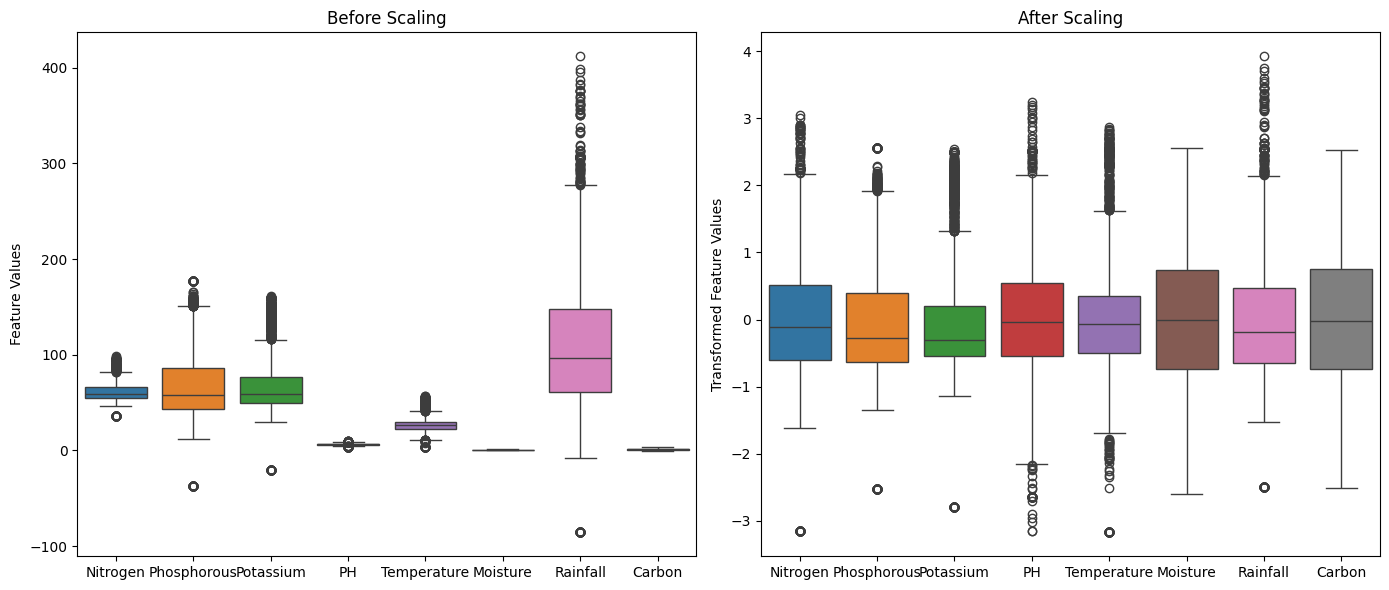

In [45]:
# Plot before scaling
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[numeric_cols])
plt.title("Before Scaling")
plt.ylabel("Feature Values")

# Apply Yeo-Johnson transformation for scaling
pt = PowerTransformer(method='yeo-johnson')
df_scaled = df.copy()
df_scaled[numeric_cols] = pt.fit_transform(df[numeric_cols])

# Plot after scaling
plt.subplot(1, 2, 2)
sns.boxplot(data=df_scaled[numeric_cols])
plt.title("After Scaling")
plt.ylabel("Transformed Feature Values")

plt.tight_layout()
plt.show()

df = df_scaled  # Proceed with scaled features


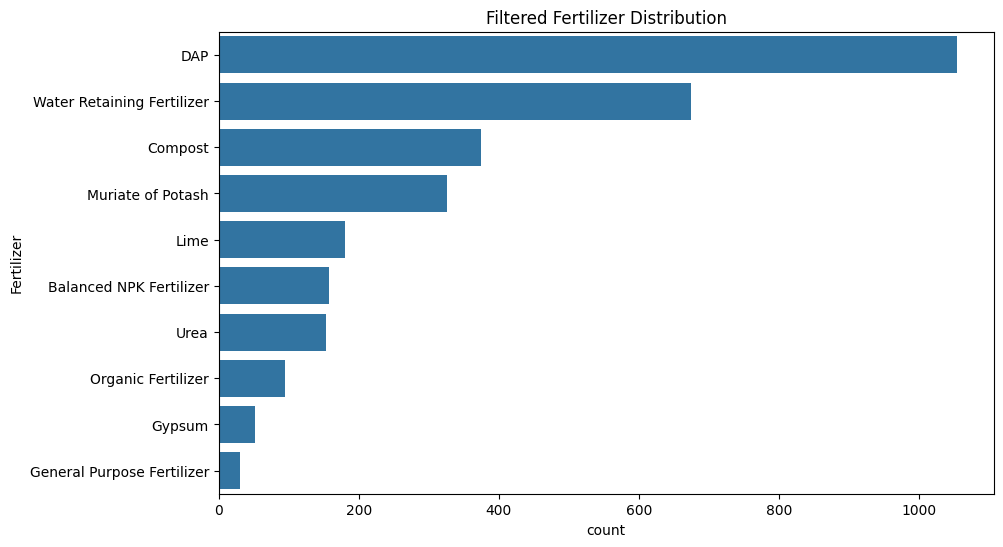

In [46]:
fertilizer_counts = df['Fertilizer'].value_counts().to_dict()
threshold = 20
fertilizers_to_keep = [f for f, count in fertilizer_counts.items() if count >= threshold]

df_filtered = df[df['Fertilizer'].isin(fertilizers_to_keep)].reset_index(drop=True)

plt.figure(figsize=(10,6))
sns.countplot(y='Fertilizer', data=df_filtered, order=df_filtered['Fertilizer'].value_counts().index)
plt.title("Filtered Fertilizer Distribution")
plt.show()

df = df_filtered


In [47]:
features = ['Nitrogen','Phosphorous','Potassium','PH','Temperature','Moisture','Rainfall','Carbon', 'Crop_le', 'Soil_le']
X = df[features]
y = df['Fertilizer_le']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (2169, 10)
Validation shape: (466, 10)
Test shape: (465, 10)


Validation Accuracy: 0.9935622317596566

Classification Report for Validation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        56
           2       0.99      1.00      1.00       158
           3       1.00      1.00      1.00         5
           4       1.00      0.88      0.93         8
           5       0.96      1.00      0.98        27
           6       1.00      1.00      1.00        49
           7       0.93      1.00      0.97        14
           8       1.00      0.91      0.95        23
           9       1.00      1.00      1.00       102

    accuracy                           0.99       466
   macro avg       0.99      0.98      0.98       466
weighted avg       0.99      0.99      0.99       466



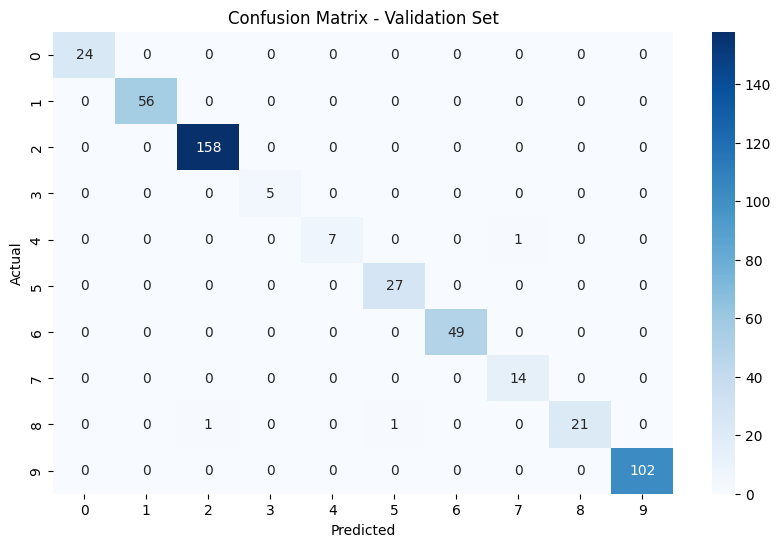

In [48]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_val = rf_model.predict(X_val)
val_acc = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", val_acc)
print("\nClassification Report for Validation:\n", classification_report(y_val, y_pred_val))

cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Test Accuracy: 0.989247311827957

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.98      0.99        56
           2       0.99      1.00      1.00       158
           3       1.00      1.00      1.00         5
           4       1.00      0.75      0.86         8
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        49
           7       0.93      1.00      0.97        14
           8       1.00      0.96      0.98        23
           9       0.99      0.99      0.99       101

    accuracy                           0.99       465
   macro avg       0.98      0.97      0.97       465
weighted avg       0.99      0.99      0.99       465



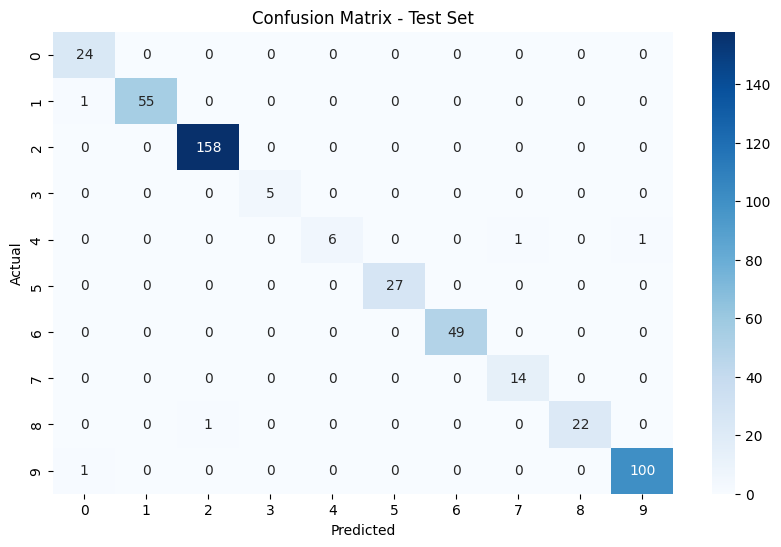

In [49]:
y_pred_test = rf_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_acc)
print("\nClassification Report for Test:\n", classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [50]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best validation accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
test_acc = best_rf.score(X_test, y_test)
print("Test accuracy:", test_acc)


Best hyperparameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best validation accuracy: 0.988933706537819
Test accuracy: 0.9827956989247312


In [51]:
import pickle

# Create a dictionary with all objects
save_dict = {
    'model': best_rf,
    'scaler': pt,
    'le_crop': le_crop,
    'le_soil': le_soil,
    'le_fert': le_fert
}

# Save to a single pickle file
with open('fertilizer_model_pipeline.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

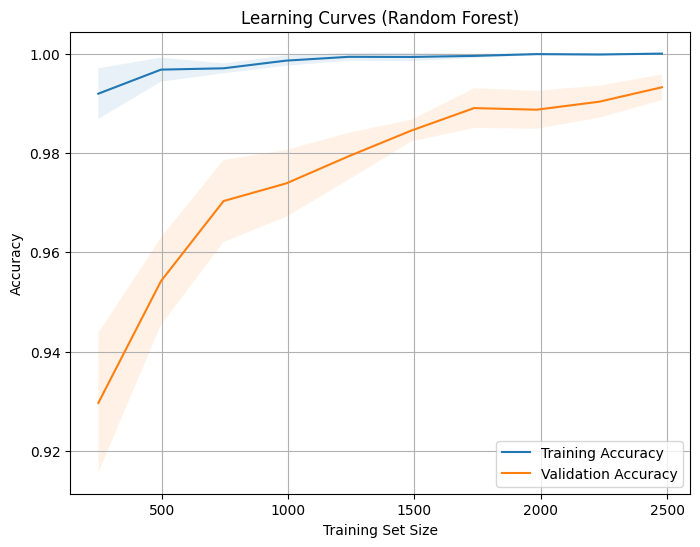

In [38]:
best_rf = RandomForestClassifier(
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
rf_model = RandomForestClassifier(
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy']

cv_results = cross_validate(
    rf_model, X, y, cv=cv, scoring=scoring,
    return_train_score=True, n_jobs=-1
)

train_scores = cv_results['train_accuracy']
val_scores = cv_results['test_accuracy']

print("Train accuracy scores:", train_scores)
print("Validation accuracy scores:", val_scores)
print("Mean training accuracy:", np.mean(train_scores))
print("Mean validation accuracy:", np.mean(val_scores))
print("Train-Val accuracy gap:", np.mean(train_scores) - np.mean(val_scores))


Train accuracy scores: [0.99959677 1.         0.99959677 1.         1.        ]
Validation accuracy scores: [0.98870968 0.99677419 0.99193548 0.99193548 0.99354839]
Mean training accuracy: 0.9998387096774193
Mean validation accuracy: 0.9925806451612903
Train-Val accuracy gap: 0.007258064516128981


In [40]:
rf = RandomForestClassifier(
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
original_acc = accuracy_score(y_test, y_pred)
print(f"Original model accuracy: {original_acc:.4f}")

y_train_shuffled = shuffle(y_train, random_state=42)

rf_perm = RandomForestClassifier(
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)
rf_perm.fit(X_train, y_train_shuffled)
y_pred_perm = rf_perm.predict(X_test)
perm_acc = accuracy_score(y_test, y_pred_perm)
print(f"Accuracy with shuffled labels: {perm_acc:.4f}")

if perm_acc >= original_acc:
    print("Warning: Model performs as well on shuffled labels. Possible overfitting or data leakage.")
else:
    print("Model performs worse on shuffled labels, implying real learned signal.")


Original model accuracy: 0.9828
Accuracy with shuffled labels: 0.3140
Model performs worse on shuffled labels, implying real learned signal.
